# Apple Health & Freestyle Libre 3 Data Analysis
## 02 - Database Creation, Merging, and Feature Engineering

This notebook ingests the cleaned datasets from Notebook 01, validates their integrity, loads them into a SQLite database, aligns Apple Health activity with Freestyle Libre glucose readings, engineers reusable features, and exports artifacts for downstream modeling.

**Notebook objectives:**
- Reload processed Apple Health and glucose datasets plus the summary metadata
- Perform data-quality diagnostics and highlight potential edge cases
- Create/refresh a SQLite database schema and populate core tables
- Align the datasets temporally and assess merge fidelity
- Engineer time-window aggregates and contextual features for modeling
- Persist merged outputs and update the project summary for Notebook 03

In [1]:
# Import libraries and configure environment
import json
import logging
import sqlite3
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display

import sys

sys.path.append("../src")

from data_merger import HealthDataMerger

# Configure logging and pandas display
logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(message)s")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)
sns.set_theme(style="whitegrid", palette="husl")

print("✅ Libraries imported and environment configured")

✅ Libraries imported and environment configured


### 1. Load processed datasets

In [2]:
# Define directories and file paths
project_root = Path("..")
processed_dir = project_root / "data" / "processed"
database_dir = project_root / "data" / "database"
sql_dir = project_root / "sql"
database_dir.mkdir(exist_ok=True)

glucose_path = processed_dir / "glucose_cleaned.csv"
health_path = processed_dir / "apple_health_cleaned.csv"
summary_path = processed_dir / "data_summary.json"

print(f"Processed directory: {processed_dir.resolve()}")


def load_dataset(path: Path, name: str, parse_dates=None) -> pd.DataFrame:
    """Load a dataset with optional datetime parsing and basic validation."""
    if not path.exists():
        logging.warning(f"{name} not found at {path}. Returning empty DataFrame.")
        return pd.DataFrame()

    df = pd.read_csv(path, parse_dates=parse_dates)
    logging.info(
        f"{name}: loaded {len(df):,} rows and {len(df.columns)} columns from {path.name}"
    )
    return df


glucose_df = load_dataset(glucose_path, name="Glucose data", parse_dates=["timestamp"])

health_date_cols = None
if health_path.exists():
    sample_health = pd.read_csv(health_path, nrows=0)
    health_date_cols = [
        col
        for col in ["startDate", "endDate", "creationDate"]
        if col in sample_health.columns
    ]

health_df = load_dataset(
    health_path, name="Apple Health data", parse_dates=health_date_cols
)


def enforce_timezone_naive(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
            if hasattr(df[col].dt, "tz") and df[col].dt.tz is not None:
                df[col] = df[col].dt.tz_convert("US/Eastern").dt.tz_localize(None)
    return df


if not glucose_df.empty:
    glucose_df = enforce_timezone_naive(glucose_df, ["timestamp"])
if not health_df.empty:
    health_df = enforce_timezone_naive(
        health_df, ["startDate", "endDate", "creationDate"]
    )

summary_metadata = {}
if summary_path.exists():
    with open(summary_path, "r") as f:
        summary_metadata = json.load(f)
        logging.info("Loaded existing data_summary.json")
else:
    logging.info("No prior data_summary.json found; starting fresh summary.")

print("\nDataset snapshots:")
display(glucose_df.head())
display(health_df.head())

[INFO] Glucose data: loaded 4,151 rows and 27 columns from glucose_cleaned.csv


Processed directory: /Users/george/Library/Mobile Documents/com~apple~CloudDocs/Programming Projects/Apple-Health-DS/data/processed


[INFO] Apple Health data: loaded 114,252 rows and 7 columns from apple_health_cleaned.csv
[INFO] Loaded existing data_summary.json
[INFO] Loaded existing data_summary.json



Dataset snapshots:


,device,serial_number,timestamp,record_type,glucose_mg_dl,scan_glucose_mg_dl,Non-numeric Rapid-Acting Insulin,rapid_acting_insulin_units,Non-numeric Food,carbohydrates_grams,Carbohydrates (servings),Non-numeric Long-Acting Insulin,long_acting_insulin_units,notes,strip_glucose_mg_dl,ketone_mmol_l,Meal Insulin (units),Correction Insulin (units),User Change Insulin (units),glucose_value,glucose_source,glucose_rate_change,glucose_trend,hour,day_of_week,is_weekend,glucose_range
0,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:20:00,0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,historic,NaN,stable,13,5,True,normal
1,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:21:00,1,NaN,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.0,scan,4.00,rising_fast,13,5,True,normal
2,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:25:00,0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0,historic,-1.25,stable,13,5,True,normal
3,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:30:00,0,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.0,historic,0.60,stable,13,5,True,normal
4,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:35:00,0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,historic,-0.40,stable,13,5,True,normal


,type,sourceName,value,unit,creationDate,startDate,endDate
0,HKQuantityTypeIdentifierBloodGlucose,Bevel,125.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:20:01,2025-08-16 13:20:01
1,HKQuantityTypeIdentifierBloodGlucose,Bevel,124.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:25:00,2025-08-16 13:25:00
2,HKQuantityTypeIdentifierBloodGlucose,Bevel,127.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:30:02,2025-08-16 13:30:02
3,HKQuantityTypeIdentifierBloodGlucose,Bevel,125.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:35:01,2025-08-16 13:35:01
4,HKQuantityTypeIdentifierBloodGlucose,Bevel,119.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:40:15,2025-08-16 13:40:15


### 2. Run data-quality diagnostics

In [3]:
def build_quality_report(
    df: pd.DataFrame,
    *,
    name: str,
    time_col: str | None = None,
    key_cols: list[str] | None = None
) -> dict:
    if df.empty:
        return {
            "dataset": name,
            "rows": 0,
            "columns": 0,
            "duplicate_rows": 0,
            "duplicate_keys": 0,
            "missing_value_pct": None,
            "min_timestamp": None,
            "max_timestamp": None,
        }

    duplicate_rows = int(df.duplicated().sum())
    duplicate_keys = None
    if key_cols:
        valid_cols = [col for col in key_cols if col in df.columns]
        duplicate_keys = (
            int(df.duplicated(subset=valid_cols).sum()) if valid_cols else None
        )

    missing_pct = float(df.isna().mean().mean()) * 100
    min_ts = (
        df[time_col].min().isoformat()
        if time_col and time_col in df.columns and df[time_col].notna().any()
        else None
    )
    max_ts = (
        df[time_col].max().isoformat()
        if time_col and time_col in df.columns and df[time_col].notna().any()
        else None
    )

    return {
        "dataset": name,
        "rows": int(len(df)),
        "columns": int(len(df.columns)),
        "duplicate_rows": duplicate_rows,
        "duplicate_keys": duplicate_keys,
        "missing_value_pct": round(missing_pct, 3),
        "min_timestamp": min_ts,
        "max_timestamp": max_ts,
    }


quality_records = [
    build_quality_report(
        glucose_df, name="glucose_df", time_col="timestamp", key_cols=["timestamp"]
    ),
    build_quality_report(
        health_df,
        name="health_df",
        time_col="startDate",
        key_cols=["startDate", "type", "sourceName"],
    ),
]

quality_report = pd.DataFrame(quality_records)
display(quality_report)


def column_missingness(df: pd.DataFrame, name: str) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame(columns=["dataset", "column", "missing_pct"])
    stats = df.isna().mean().sort_values(ascending=False) * 100
    return pd.DataFrame(
        {
            "dataset": name,
            "column": stats.index,
            "missing_pct": stats.values.round(3),
        }
    )


missingness = pd.concat(
    [
        column_missingness(glucose_df, "glucose_df"),
        column_missingness(health_df, "health_df"),
    ],
    ignore_index=True,
)
display(missingness.head(20))

print("🔎 Data-quality diagnostics completed.")

,dataset,rows,columns,duplicate_rows,duplicate_keys,missing_value_pct,min_timestamp,max_timestamp
0,glucose_df,4151,27,0,0,51.853,2025-08-16T13:20:00,2025-08-30T17:54:00
1,health_df,114252,7,1689,2671,0.570,2025-08-16T13:20:00,2025-08-30T17:54:00


,dataset,column,missing_pct
0,glucose_df,notes,100.000
1,glucose_df,carbohydrates_grams,100.000
2,glucose_df,User Change Insulin (units),100.000
3,glucose_df,Correction Insulin (units),100.000
4,glucose_df,Meal Insulin (units),100.000
5,glucose_df,ketone_mmol_l,100.000
6,glucose_df,strip_glucose_mg_dl,100.000
7,glucose_df,long_acting_insulin_units,100.000
8,glucose_df,Non-numeric Long-Acting Insulin,100.000
9,glucose_df,Carbohydrates (servings),100.000


🔎 Data-quality diagnostics completed.


### 3. Initialize SQLite database

In [4]:
database_path = database_dir / "health_glucose.db"
conn = sqlite3.connect(database_path)
print(f"📦 SQLite database located at: {database_path.resolve()}")

schema_path = sql_dir / "schema.sql"
if schema_path.exists():
    with open(schema_path, "r") as f:
        schema_sql = f.read()
    with conn:
        conn.executescript(schema_sql)
    logging.info("Executed schema.sql to initialize tables and indexes.")
else:
    logging.warning("schema.sql not found; relying on pandas to_sql definitions.")

if not glucose_df.empty:
    glucose_df.to_sql("glucose_readings", conn, if_exists="replace", index=False)
    logging.info("Loaded glucose_readings table into SQLite.")
if not health_df.empty:
    health_df.to_sql("apple_health_records", conn, if_exists="replace", index=False)
    logging.info("Loaded apple_health_records table into SQLite.")

table_counts = []
for table_name in ["glucose_readings", "apple_health_records"]:
    try:
        count = pd.read_sql(f"SELECT COUNT(*) AS count FROM {table_name}", conn)[
            "count"
        ].iloc[0]
        table_counts.append({"table": table_name, "row_count": int(count)})
    except Exception as exc:
        logging.error(f"Failed to count rows in {table_name}: {exc}")
        table_counts.append({"table": table_name, "row_count": None})

print("📊 Table row counts:")
display(pd.DataFrame(table_counts))

[INFO] Executed schema.sql to initialize tables and indexes.
[INFO] Loaded glucose_readings table into SQLite.
[INFO] Loaded glucose_readings table into SQLite.


📦 SQLite database located at: /Users/george/Library/Mobile Documents/com~apple~CloudDocs/Programming Projects/Apple-Health-DS/data/database/health_glucose.db


[INFO] Loaded apple_health_records table into SQLite.


📊 Table row counts:


,table,row_count
0,glucose_readings,4151
1,apple_health_records,114252


### 4. Align health and glucose datasets

In [5]:
merger = HealthDataMerger()
tolerance_minutes = 15
window_minutes = 60

if health_df.empty or glucose_df.empty:
    logging.warning("One or both datasets are empty. Merge operations will be skipped.")
    merged_df = pd.DataFrame()
    windowed_df = pd.DataFrame()
    correlations = {}
else:
    merger.load_apple_health_data(health_df)
    merger.load_glucose_data(glucose_df)

    merged_df = merger.align_timestamps(tolerance_minutes=tolerance_minutes)
    merged_df = merger.add_contextual_features(merged_df)
    merger.merged_data = merged_df

    windowed_df = merger.create_time_windows(window_minutes=window_minutes)
    correlations = merger.get_correlation_analysis()

    matched_pct = len(merged_df) / len(health_df) * 100 if len(health_df) else np.nan
    logging.info(
        f"Aligned {len(merged_df):,} records ({matched_pct:.1f}% of Apple Health rows) within ±{tolerance_minutes} minutes."
    )
    logging.info(
        f"Windowed dataset contains {len(windowed_df):,} aggregated rows ({window_minutes}-minute bins)."
    )

print("Merged data preview:")
display(merged_df.head())

print("\nHourly window preview:")
display(windowed_df.head())

if correlations:
    print("\nTop correlations with glucose_value:")
    for metric, corr in list(correlations.items())[:10]:
        print(f"  {metric}: {corr:.3f}")
else:
    print("\nNo correlations available (merged dataset empty).")

[INFO] Loaded 114252 Apple Health records
[INFO] Loaded 4151 glucose records
[INFO] Loaded 4151 glucose records
[INFO] Merged data contains 114252 aligned records
[INFO] Merged data contains 114252 aligned records
[INFO] Created 341 time windows
[INFO] Created 341 time windows
[INFO] Aligned 114,252 records (100.0% of Apple Health rows) within ±15 minutes.
[INFO] Windowed dataset contains 341 aggregated rows (60-minute bins).
[INFO] Aligned 114,252 records (100.0% of Apple Health rows) within ±15 minutes.
[INFO] Windowed dataset contains 341 aggregated rows (60-minute bins).


Merged data preview:


,type,sourceName,value,unit,creationDate,health_timestamp,endDate,device,serial_number,glucose_timestamp,record_type,glucose_mg_dl,scan_glucose_mg_dl,Non-numeric Rapid-Acting Insulin,rapid_acting_insulin_units,Non-numeric Food,carbohydrates_grams,Carbohydrates (servings),Non-numeric Long-Acting Insulin,long_acting_insulin_units,notes,strip_glucose_mg_dl,ketone_mmol_l,Meal Insulin (units),Correction Insulin (units),User Change Insulin (units),glucose_value,glucose_source,glucose_rate_change,glucose_trend,hour,day_of_week,is_weekend,glucose_range,time_diff_minutes,is_night,is_morning,is_afternoon,is_evening,likely_meal_time
0,HKQuantityTypeIdentifierHeartRate,Zepp,78.000,count/min,2025-08-17 00:48:15,2025-08-16 13:20:00,2025-08-16 13:20:59,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:20:00,0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,historic,NaN,stable,13,5,True,normal,0.000,False,False,True,False,True
1,HKQuantityTypeIdentifierAppleStandTime,George’s Apple Watch,3.000,min,2025-08-16 13:25:35,2025-08-16 13:20:00,2025-08-16 13:25:00,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:20:00,0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,historic,NaN,stable,13,5,True,normal,0.000,False,False,True,False,True
2,HKQuantityTypeIdentifierActiveEnergyBurned,Zepp,1.000,Cal,2025-09-19 22:50:35,2025-08-16 13:20:00,2025-08-16 13:29:59,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:20:00,0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,historic,NaN,stable,13,5,True,normal,0.000,False,False,True,False,True
3,HKQuantityTypeIdentifierBloodGlucose,Bevel,125.000,mg/dL,2025-08-17 00:38:00,2025-08-16 13:20:01,2025-08-16 13:20:01,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:20:00,0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,historic,NaN,stable,13,5,True,normal,0.017,False,False,True,False,True
4,HKQuantityTypeIdentifierActiveEnergyBurned,George’s Apple Watch,0.465,Cal,2025-08-16 13:21:13,2025-08-16 13:20:12,2025-08-16 13:20:53,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:20:00,0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,historic,NaN,stable,13,5,True,normal,0.200,False,False,True,False,True



Hourly window preview:


,glucose_timestamp,glucose_value_mean,glucose_value_std,glucose_value_count,value_mean,value_sum,time_diff_minutes_mean,type_mode,glucose_range_mode,glucose_trend_mode,sourceName_mode
0,2025-08-16 13:00:00,117.228,11.657,158,34.434,5440.612,-0.037,HKQuantityTypeIdentifierActiveEnergyBurned,normal,stable,George’s Apple Watch
1,2025-08-16 14:00:00,95.036,5.151,249,34.901,8655.517,-0.039,HKQuantityTypeIdentifierHeartRate,normal,stable,George’s Apple Watch
2,2025-08-16 15:00:00,110.229,4.847,192,39.052,7458.940,-0.042,HKQuantityTypeIdentifierHeartRate,normal,stable,George’s Apple Watch
3,2025-08-16 16:00:00,102.241,5.502,286,37.850,10787.318,0.188,HKQuantityTypeIdentifierHeartRate,normal,stable,George’s Apple Watch
4,2025-08-16 17:00:00,100.848,3.394,328,35.932,11749.789,0.054,HKQuantityTypeIdentifierHeartRate,normal,stable,George’s Apple Watch



Top correlations with glucose_value:
  glucose_mg_dl: 1.000
  scan_glucose_mg_dl: 1.000
  hour: 0.293
  day_of_week: 0.206
  glucose_rate_change: 0.107
  value: -0.028
  record_type: 0.006
  time_diff_minutes: 0.002


### 5. Exploratory summaries and visual checks

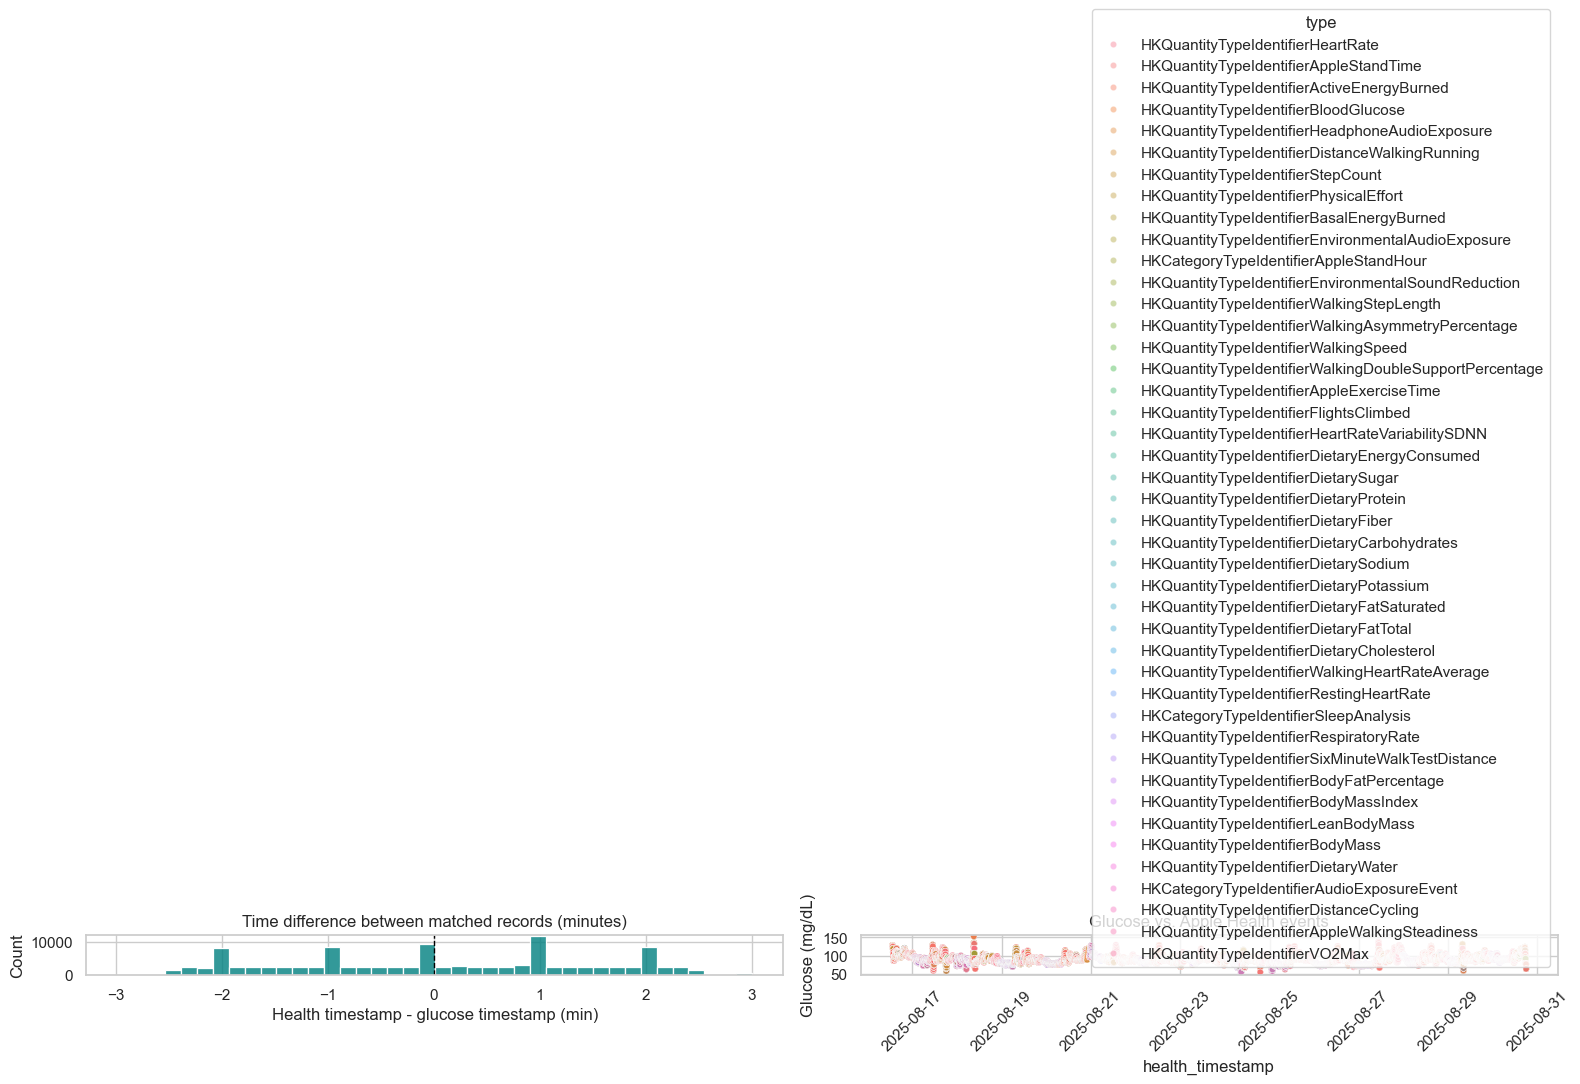


Merged glucose summary statistics:


,count,mean,std,min,25%,50%,75%,max
glucose_value,114252.0,91.29,10.37,53.0,85.0,91.0,96.0,153.0


,metric,correlation
0,glucose_mg_dl,1.000
1,scan_glucose_mg_dl,1.000
2,hour,0.293
3,day_of_week,0.206
4,glucose_rate_change,0.107
5,value,-0.028
6,record_type,0.006
7,time_diff_minutes,0.002


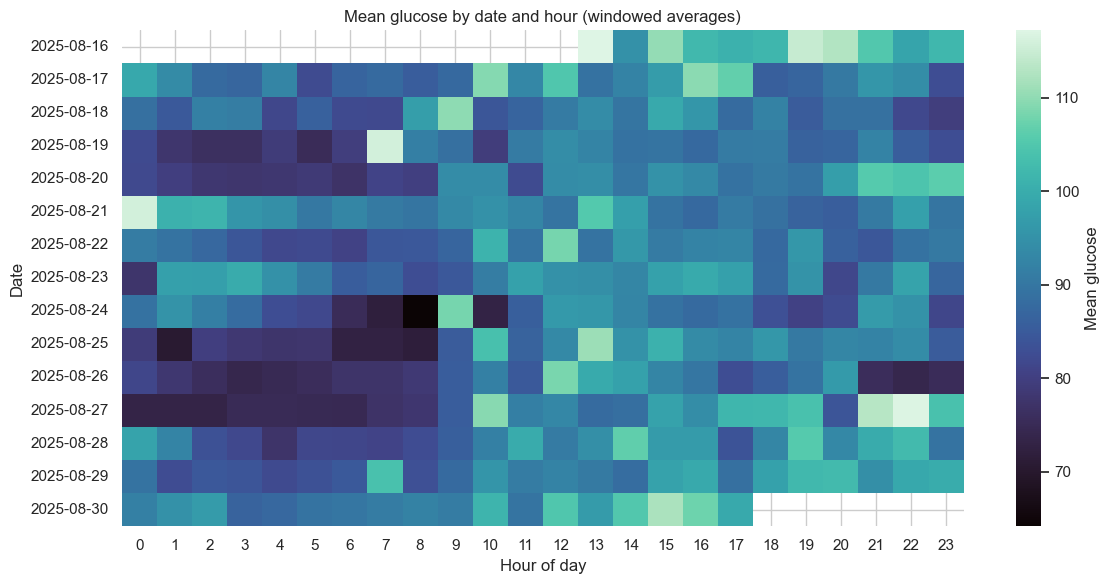

In [6]:
if merged_df.empty:
    print("⚠️  Skipping visual diagnostics because merged data is empty.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.histplot(
        merged_df["time_diff_minutes"], bins=40, ax=axes[0], color="teal", alpha=0.8
    )
    axes[0].set_title("Time difference between matched records (minutes)")
    axes[0].axvline(0, color="black", linestyle="--", linewidth=1)
    axes[0].set_xlabel("Health timestamp - glucose timestamp (min)")

    if {"health_timestamp", "glucose_value"} <= set(merged_df.columns):
        scatter_kwargs = {
            "data": merged_df,
            "x": "health_timestamp",
            "y": "glucose_value",
            "ax": axes[1],
            "alpha": 0.4,
            "s": 20,
        }
        if "type" in merged_df.columns:
            scatter_kwargs["hue"] = "type"
        sns.scatterplot(**scatter_kwargs)
        axes[1].set_title("Glucose vs. Apple Health events")
        axes[1].set_ylabel("Glucose (mg/dL)")
        axes[1].tick_params(axis="x", rotation=45)
    else:
        axes[1].text(
            0.5, 0.5, "Insufficient columns for scatter plot", ha="center", va="center"
        )
        axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    if "glucose_value" in merged_df.columns:
        merged_summary = merged_df[["glucose_value"]].describe().T
        print("\nMerged glucose summary statistics:")
        display(merged_summary)

    if correlations:
        corr_df = pd.DataFrame(
            list(correlations.items()), columns=["metric", "correlation"]
        ).head(15)
        display(corr_df)
    else:
        print("No correlations available for display.")

    if not windowed_df.empty and {"glucose_timestamp", "glucose_value_mean"} <= set(
        windowed_df.columns
    ):
        hourly = windowed_df[["glucose_timestamp", "glucose_value_mean"]].copy()
        hourly["date"] = hourly["glucose_timestamp"].dt.date
        hourly["hour"] = hourly["glucose_timestamp"].dt.hour
        pivot = hourly.pivot_table(
            values="glucose_value_mean", index="date", columns="hour", aggfunc="mean"
        )
        plt.figure(figsize=(12, 6))
        sns.heatmap(pivot, cmap="mako", cbar_kws={"label": "Mean glucose"})
        plt.title("Mean glucose by date and hour (windowed averages)")
        plt.xlabel("Hour of day")
        plt.ylabel("Date")
        plt.tight_layout()
        plt.show()

### 6. Export merged datasets, features, and updated summary

In [9]:
exports = []
skipped_exports = []


def safe_to_parquet(df: pd.DataFrame, path: Path) -> bool:
    try:
        df.to_parquet(path, index=False)
        return True
    except ImportError as err:
        logging.warning(f"Skipping parquet export for {path.name}: {err}")
        skipped_exports.append({"artifact": path.name, "reason": str(err)})
        return False
    except Exception as exc:
        logging.error(f"Failed to export {path.name}: {exc}")
        skipped_exports.append({"artifact": path.name, "reason": str(exc)})
        return False


if not merged_df.empty:
    merged_csv = processed_dir / "merged_health_glucose.csv"
    merged_df.to_csv(merged_csv, index=False)
    exports.append({"artifact": merged_csv.name, "rows": len(merged_df)})

    merged_parquet = processed_dir / "merged_health_glucose.parquet"
    if safe_to_parquet(merged_df, merged_parquet):
        exports.append({"artifact": merged_parquet.name, "rows": len(merged_df)})

if not windowed_df.empty:
    window_csv = processed_dir / "windowed_features_hourly.csv"
    windowed_df.to_csv(window_csv, index=False)
    exports.append({"artifact": window_csv.name, "rows": len(windowed_df)})

    window_parquet = processed_dir / "windowed_features_hourly.parquet"
    if safe_to_parquet(windowed_df, window_parquet):
        exports.append({"artifact": window_parquet.name, "rows": len(windowed_df)})

if exports:
    print("💾 Export summary:")
    display(pd.DataFrame(exports))
else:
    print("⚠️  No exports created because merged/windowed datasets are empty.")

if skipped_exports:
    print("\n⚠️  Skipped exports:")
    display(pd.DataFrame(skipped_exports))
    print(
        "   ➥ Install optional dependency 'pyarrow' or 'fastparquet' to enable parquet outputs."
    )

updated_summary = summary_metadata.copy()
updated_summary["notebook_02"] = {
    "run_timestamp": datetime.now().isoformat(),
    "merge_tolerance_minutes": (
        tolerance_minutes if "tolerance_minutes" in locals() else None
    ),
    "merged_records": int(len(merged_df)) if "merged_df" in locals() else 0,
    "windowed_records": int(len(windowed_df)) if "windowed_df" in locals() else 0,
    "merged_time_range": {
        "start": (
            merged_df["health_timestamp"].min().isoformat()
            if not merged_df.empty and "health_timestamp" in merged_df.columns
            else None
        ),
        "end": (
            merged_df["health_timestamp"].max().isoformat()
            if not merged_df.empty and "health_timestamp" in merged_df.columns
            else None
        ),
    },
    "glucose_time_range": {
        "start": (
            merged_df["glucose_timestamp"].min().isoformat()
            if not merged_df.empty and "glucose_timestamp" in merged_df.columns
            else None
        ),
        "end": (
            merged_df["glucose_timestamp"].max().isoformat()
            if not merged_df.empty and "glucose_timestamp" in merged_df.columns
            else None
        ),
    },
    "top_correlations": correlations,
    "data_quality": quality_report.to_dict(orient="records"),
}

with open(summary_path, "w") as f:
    json.dump(updated_summary, f, indent=2)
logging.info(f"Updated summary metadata written to {summary_path.name}")

conn.close()
print("🔚 Database connection closed.")
print("🎯 Notebook 02 pipeline completed successfully!")

[ERROR] Failed to export merged_health_glucose.parquet: No type extension with name arrow.py_extension_type found
[ERROR] Failed to export windowed_features_hourly.parquet: A type extension with name pandas.period already defined
[ERROR] Failed to export windowed_features_hourly.parquet: A type extension with name pandas.period already defined


💾 Export summary:


,artifact,rows
0,merged_health_glucose.csv,114252
1,windowed_features_hourly.csv,341



⚠️  Skipped exports:


,artifact,reason
0,merged_health_glucose.parquet,No type extension with name arrow.py_extension...
1,windowed_features_hourly.parquet,A type extension with name pandas.period alrea...


[INFO] Updated summary metadata written to data_summary.json


   ➥ Install optional dependency 'pyarrow' or 'fastparquet' to enable parquet outputs.
🔚 Database connection closed.
🎯 Notebook 02 pipeline completed successfully!


### Next steps
- Explore predictive modeling and feature selection in Notebook 03 using the exported merged datasets.
- Prototype SQL-first dashboards or Looker Studio connections leveraging the SQLite database.
- Continue iterating on data-quality checks as new Apple Health or Libre exports are added.